# Baseline Models (No Graph Structure)

Tests if using temporal feature aggregations improves classification performance.
Models: Logistic Regression, Random Forest, XGBoost

In [ ]:
import sys
from pathlib import Path

# Add project root to path (notebooks/experiments -> notebooks -> root)
ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_observation_window_graphs
)

import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

np.random.seed(42)

## Configuration

In [ ]:
CONFIG = {
    'data_dir': '../../elliptic_dataset',
    'train_timesteps': (5, 29),
    'val_timesteps': (30, 33),
    'test_timesteps': (34, 42),
    'observation_windows': [0, 3, 5, 7],
    'device': 'cpu'
}

## Load Data

In [ ]:
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../../graph_cache',
    use_cache=True,
    verbose=False
)

split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

print(f"Train: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")

## Prepare Graphs

In [4]:
graphs = prepare_observation_window_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=torch.device(CONFIG['device'])
)


PREPARING OBSERVATION WINDOW GRAPHS (CORRECT IMPLEMENTATION)

Split boundaries:
  Train: first_appearance <= 29
  Val:   first_appearance <= 33
  Test:  first_appearance <= 42

Observation windows: K = [0, 3, 5, 7]

K = 0 (Observe nodes for 0 timesteps after first appearance)

TRAIN split:
  Split period: nodes with first_appearance <= 29
  Evaluation time: t = 29 + 0 = 29
  Building graph at t=29...
  Graph: 474,120 nodes, 1,510,474 edges
  Eval nodes: 109,133 (23.02% of graph)
    Licit: 101,896 (93.4%)
    Illicit: 7,237 (6.6%)

VAL split:
  Split period: nodes with first_appearance <= 33
  Evaluation time: t = 33 + 0 = 33
  Building graph at t=33...
  Graph: 521,595 nodes, 1,787,166 edges
  Eval nodes: 16,718 (3.21% of graph)
    Licit: 15,413 (92.2%)
    Illicit: 1,305 (7.8%)

TEST split:
  Split period: nodes with first_appearance <= 42
  Evaluation time: t = 42 + 0 = 42
  Building graph at t=42...
  Graph: 697,242 nodes, 2,215,839 edges
  Eval nodes: 50,876 (7.30% of graph)
   

## Training Functions

In [5]:
def evaluate_model(model, X, y, scaler=None):
    """Evaluate model and return metrics."""
    if scaler is not None:
        X = scaler.transform(X)
    
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(y, y_proba) if len(np.unique(y)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}


def train_baseline(model_class, model_params, K, graphs):
    """Train a baseline model for a specific K."""
    # Extract data
    train_data = graphs[K]['train']
    val_data = graphs[K]['val']
    test_data = graphs[K]['test']
    
    X_train = train_data.x[train_data.eval_mask].cpu().numpy()
    y_train = train_data.y[train_data.eval_mask].cpu().numpy()
    X_val = val_data.x[val_data.eval_mask].cpu().numpy()
    y_val = val_data.y[val_data.eval_mask].cpu().numpy()
    X_test = test_data.x[test_data.eval_mask].cpu().numpy()
    y_test = test_data.y[test_data.eval_mask].cpu().numpy()
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Class weights
    class_counts = np.bincount(y_train)
    class_weight = {0: len(y_train) / (2 * class_counts[0]), 1: len(y_train) / (2 * class_counts[1])}
    
    # Train
    if 'class_weight' in model_params:
        model_params['class_weight'] = class_weight
    if 'scale_pos_weight' in model_params:
        model_params['scale_pos_weight'] = class_weight[1] / class_weight[0]
    
    model = model_class(**model_params)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_metrics = evaluate_model(model, X_train, y_train, scaler)
    val_metrics = evaluate_model(model, X_val, y_val, scaler)
    test_metrics = evaluate_model(model, X_test, y_test, scaler)
    
    return {'train': train_metrics, 'val': val_metrics, 'test': test_metrics, 'model': model}

## Train Models

In [6]:
models_config = {
    'LogisticRegression': (LogisticRegression, {'max_iter': 1000, 'class_weight': 'balanced', 'random_state': 42}),
    'RandomForest': (RandomForestClassifier, {'n_estimators': 100, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}),
    'XGBoost': (XGBClassifier, {'n_estimators': 100, 'scale_pos_weight': 1.0, 'random_state': 42, 'eval_metric': 'logloss'})
}

results = {}

for model_name, (model_class, model_params) in models_config.items():
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print('='*70)
    
    results[model_name] = {}
    
    for K in CONFIG['observation_windows']:
        print(f"\nK={K}:", end=' ')
        result = train_baseline(model_class, model_params.copy(), K, graphs)
        results[model_name][K] = result
        
        print(f"Test F1={result['test']['f1']:.4f}, AUC={result['test']['auc']:.4f}")

print("\n" + "="*70)
print("Training complete!")
print("="*70)


LogisticRegression

K=0: Test F1=0.1928, AUC=0.9012

K=3: Test F1=0.1864, AUC=0.8956

K=5: Test F1=0.1834, AUC=0.8966

K=7: Test F1=0.1897, AUC=0.9008

RandomForest

K=0: Test F1=0.3207, AUC=0.8669

K=3: Test F1=0.3258, AUC=0.8625

K=5: Test F1=0.3363, AUC=0.8925

K=7: Test F1=0.3228, AUC=0.8707

XGBoost

K=0: Test F1=0.6978, AUC=0.9279

K=3: Test F1=0.6307, AUC=0.9256

K=5: Test F1=0.6853, AUC=0.9348

K=7: Test F1=0.6380, AUC=0.9320

Training complete!


## Results Summary

In [ ]:
# Create comparison table
comparison_data = []

for model_name in models_config.keys():
    for K in CONFIG['observation_windows']:
        metrics = results[model_name][K]['test']
        comparison_data.append({
            'Model': model_name,
            'K': K,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1': f"{metrics['f1']:.4f}",
            'AUC': f"{metrics['auc']:.4f}"
        })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))

## Performance by K

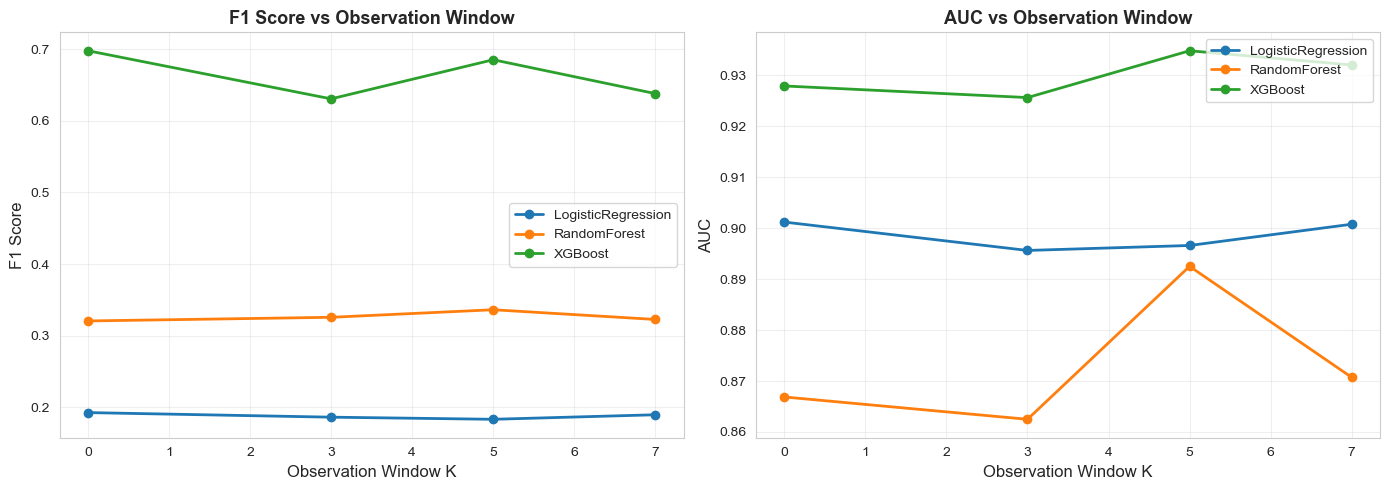

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score
ax = axes[0]
for model_name in models_config.keys():
    f1_scores = [results[model_name][K]['test']['f1'] for K in CONFIG['observation_windows']]
    ax.plot(CONFIG['observation_windows'], f1_scores, marker='o', label=model_name, linewidth=2)

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
for model_name in models_config.keys():
    auc_scores = [results[model_name][K]['test']['auc'] for K in CONFIG['observation_windows']]
    ax.plot(CONFIG['observation_windows'], auc_scores, marker='o', label=model_name, linewidth=2)

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import os
os.makedirs('../../results', exist_ok=True)

comparison_df.to_csv('../../results/baseline_results.csv', index=False)
print("Results saved to ../../results/baseline_results.csv")